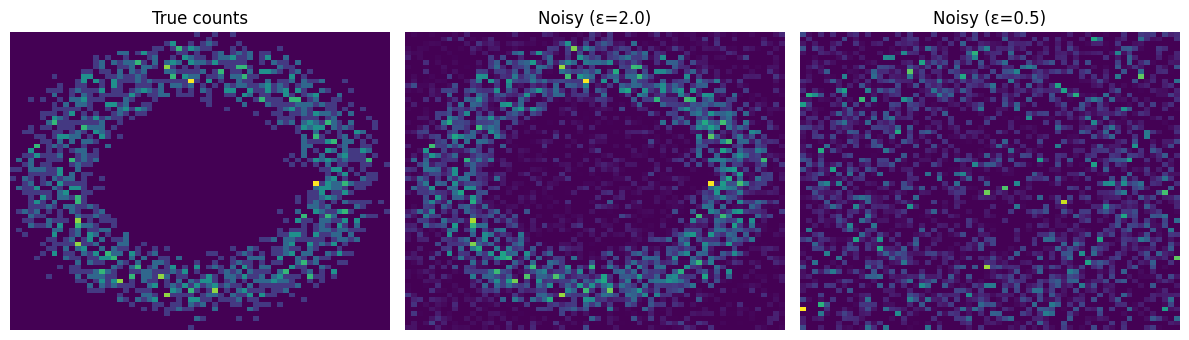

Parameter Search Start here
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.15/5 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.15/10 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.15/15 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.2/5 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.2/10 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.2/15 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.25/5 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.25/10 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=32x32, DBSCAN=0.25/15 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=48x48, DBSCAN=0.15/5 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=48x48, DBSCAN=0.15/10 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=48x48, DBSCAN=0.15/15 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=48x48, DBSCAN=0.2/5 --> AMI=0.000, ARI=0.000
eps=0.30, T=1.00, grid=48x48, DBSCAN=0.2/10 --> AMI=0.000, ARI=0.000
ep

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Make grid
def make_grid(points, xlim, ylim, n_x, n_y):
    xs = np.linspace(xlim[0], xlim[1], n_x + 1)
    ys = np.linspace(ylim[0], ylim[1], n_y + 1)

    # digitize returns [1, len(xs)], so subtract 1
    xi = np.clip(np.digitize(points[:, 0], xs) - 1, 0, n_x - 1)
    yi = np.clip(np.digitize(points[:, 1], ys) - 1, 0, n_y - 1)

    H = np.zeros((n_x, n_y), dtype=float)
    np.add.at(H, (xi, yi), 1)
    return H, xs, ys

# Add Laplace noises
def laplace_mech(counts, epsilon, clip_zero=True, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    b = 1.0 / float(epsilon)
    noise = rng.laplace(loc=0.0, scale=b, size=counts.shape)
    out = counts + noise
    if clip_zero:
        out = np.maximum(out, 0.0)
    return out, noise

# Connect components over threshold T
def spans_from_noisy(noisy, threshold_T):
    active = noisy >= threshold_T
    visited = np.zeros_like(active, dtype=bool)
    spans = []

    n_x, n_y = active.shape

    for i in range(n_x):
        for j in range(n_y):
            if active[i, j] and not visited[i, j]:
                stack = [(i, j)]
                visited[i, j] = True
                xs = [i]
                ys = [j]

                # DFS / flood fill
                while stack:
                    x, y = stack.pop()
                    for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                        xx, yy = x + dx, y + dy
                        if 0 <= xx < n_x and 0 <= yy < n_y:
                            if active[xx, yy] and not visited[xx, yy]:
                                visited[xx, yy] = True
                                stack.append((xx, yy))
                                xs.append(xx)
                                ys.append(yy)

                spans.append((min(xs), min(ys), max(xs), max(ys)))

    return spans


# Convert span indices (cell indices) into continuous coordinates (x_min, y_min, x_max, y_max)
def boxes_to_world(spans, xs, ys):
    dx, dy = xs[1] - xs[0], ys[1] - ys[0]
    world = []
    for (x1, y1, x2, y2) in spans:
        world.append((xs[x1], ys[y1], xs[x2] + dx, ys[y2] + dy))
    return world

# Assign labels according to spans
def assign_labels_from_spans(points, spans_world):
    labels = np.full(len(points), -1, dtype=int)
    for k, (xmin, ymin, xmax, ymax) in enumerate(spans_world):
        mask = (
            (points[:, 0] >= xmin) & (points[:, 0] < xmax) &
            (points[:, 1] >= ymin) & (points[:, 1] < ymax)
        )
        labels[mask] = k
    return labels


# Evaluate based on AMI and ARI
def evaluate_dp_params(X, eps_priv, T, n_x, n_y, db_eps, db_min):
    # Grid counts
    H, xs, ys = make_grid(
        X,
        (X[:, 0].min(), X[:, 0].max()),
        (X[:, 1].min(), X[:, 1].max()),
        n_x=n_x,
        n_y=n_y
    )

    # DP noise
    noisy, _ = laplace_mech(H, epsilon=eps_priv, clip_zero=True)

    # Spans from thresholded noisy grid
    spans = spans_from_noisy(noisy, threshold_T=T)
    spans_world = boxes_to_world(spans, xs, ys)
    y_pred = assign_labels_from_spans(X, spans_world)

    # Ground-truth clustering 
    y_true = DBSCAN(eps=db_eps, min_samples=db_min).fit_predict(X)

    # Compute AMI & ARI only on points that have labels in both
    idx = (y_true != -1) & (y_pred != -1)
    if idx.any():
        AMI = adjusted_mutual_info_score(y_true[idx], y_pred[idx])
        ARI = adjusted_rand_score(y_true[idx], y_pred[idx])
    else:
        AMI = 0.0
        ARI = 0.0

    return AMI, ARI, spans, xs, ys, noisy


# Grid search and optimize by AMI, ARI
if __name__ == "__main__":
    X, _ = make_circles(n_samples=2000, noise=0.08, random_state=0)


    # grid + counts
    H, xs, ys = make_grid(X, (X[:,0].min(), X[:,0].max()),
                         (X[:,1].min(), X[:,1].max()),
                         n_x=64, n_y=64)

    # noise with different eps
    noisy1, _ = laplace_mech(H, epsilon=4, clip_zero=True)       
    noisy2, _ = laplace_mech(H, epsilon=0.5, clip_zero=True)

    # plot
    fig, axs = plt.subplots(1,3, figsize=(12,3.5))
    axs[0].imshow(H.T, origin='lower', aspect='auto'); axs[0].set_title('True counts')
    axs[1].imshow(noisy1.T, origin='lower', aspect='auto'); axs[1].set_title('Noisy (ε=2.0)')
    axs[2].imshow(noisy2.T, origin='lower', aspect='auto'); axs[2].set_title('Noisy (ε=0.5)')
    for ax in axs: ax.axis('off')
    plt.tight_layout(); plt.show()

    # search space 
    eps_candidates = [0.3, 0.5, 1.0, 2.0, 3.5, 4.0]
    T_candidates = [1.0, 1.5, 1.7, 2.0, 2.5]
    grid_sizes = [(32, 32), (48, 48), (64, 64)]
    dbscan_eps_vals = [0.15, 0.20, 0.25]
    dbscan_min_vals = [5, 10, 15]

    best_ari = -1.0
    best_conf = None
    best_outputs = None
    best_ami_for_best_ari = None

    print("Parameter Search Start here")

    for eps_priv in eps_candidates:
        for T in T_candidates:
            for nx, ny in grid_sizes:
                for dbe in dbscan_eps_vals:
                    for dbm in dbscan_min_vals:

                        AMI, ARI, spans, xs, ys, noisy = evaluate_dp_params(
                            X, eps_priv, T, nx, ny, dbe, dbm
                        )

                        print(
                            f"eps={eps_priv:.2f}, T={T:.2f}, "
                            f"grid={nx}x{ny}, DBSCAN={dbe}/{dbm} "
                            f"--> AMI={AMI:.3f}, ARI={ARI:.3f}"
                        )

                        # Optimization criterion: maximize ARI
                        if ARI > best_ari:
                            best_ari = ARI
                            best_ami_for_best_ari = AMI
                            best_conf = (eps_priv, T, nx, ny, dbe, dbm)
                            best_outputs = (spans, xs, ys, noisy)

    print(" BEST PARAMETERS (by ARI):")
    eps_priv, T, nx, ny, dbe, dbm = best_conf
    print(f"Epsilon (privacy):      {eps_priv}")
    print(f"Threshold T:            {T}")
    print(f"Grid size:              {nx} x {ny}")
    print(f"DBSCAN eps / min_samp:  {dbe} / {dbm}")
    print(f"Best ARI:               {best_ari:.4f}")
    print(f"AMI at best ARI:        {best_ami_for_best_ari:.4f}")

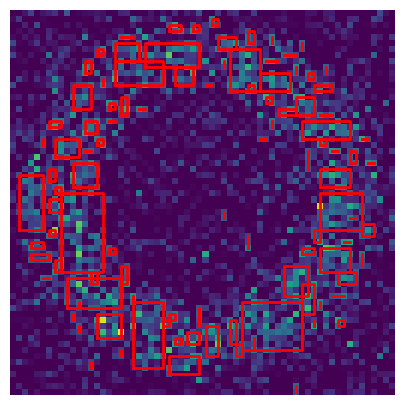

In [24]:
# PLOT for eps = 2 and T = 1.2

eps_priv = 2
T = 1.2
nx = ny = 64   

# 1) Build grid
H, xs, ys = make_grid(
    X,
    (X[:,0].min(), X[:,0].max()),
    (X[:,1].min(), X[:,1].max()),
    n_x=nx, n_y=ny
)

# Add Laplace noise
noisy, _ = laplace_mech(H, epsilon=eps_priv, clip_zero=True)

# Extract spans
spans = spans_from_noisy(noisy, threshold_T=T)

# Convert spans to world boxes
spans_world = boxes_to_world(spans, xs, ys)

# Predicted labels from DP spans
y_pred = assign_labels_from_spans(X, spans_world)

# Ground-truth via DBSCAN 
db_eps = 0.20
db_min = 10
y_true = DBSCAN(eps=db_eps, min_samples=db_min).fit_predict(X)

# Only compare non-noise points on both sides
idx = (y_true != -1) & (y_pred != -1)

if idx.any():
    AMI = adjusted_mutual_info_score(y_true[idx], y_pred[idx])
    ARI = adjusted_rand_score(y_true[idx], y_pred[idx])
else:
    AMI = 0.0
    ARI = 0.0

# 4) Plot DP noisy histogram + spans
plt.figure(figsize=(6,5))
plt.imshow(noisy.T, origin="lower", cmap="viridis")

for (x1, y1, x2, y2) in spans:
    plt.plot(
        [x1, x2, x2, x1, x1],
        [y1, y1, y2, y2, y1],
        "r-", lw=2
    )

plt.axis("off")
plt.show()
